In [3]:
import xmitgcm as xm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.figure_factory as ff
import sys
import xarray as xr

%matplotlib inline
%config InlineBackend.figure_format='retina'

Note that 2-D and 3-D arrays should be index-ordered as $(y,x)$ and $(z, y, x)$ respectively, to be written in proper ordering for MITgcm.

In [4]:
# Writing utility
def writefield(fname, data, dtype=np.dtype("float32")):
    dcopy = data.copy()
    print("write to file: " + fname)
    if dcopy.dtype != dtype:
        dcopy = dcopy.astype(dtype)
        print("changed dtype to " + str(dcopy.dtype))
    if sys.byteorder == "little":
        dcopy.byteswap(True)
    fid = open(fname, "wb")
    dcopy.tofile(fid)
    fid.close()

In [5]:
def openfield(fname, shape, dtype=np.dtype("float32")):
    data = np.fromfile(fname, dtype)
    if sys.byteorder == "little":
        data.byteswap(True)
    return data.reshape(shape)

# Set up grid

In [6]:
Ho = 3982.2607  # ocean depth in meters

Lx = 1000
Ly = 2000

nx = 200  # number of gridpoints in x-direction - 1000km/5km
ny = 400  # number of gridpoints in y-direction - 2000km/5km
nz = 49  # number of vertical levels

dx = Lx / nx
dy = Ly / ny

X = np.linspace(0, Lx, nx, dtype="float32")
Y = np.linspace(0, Ly, ny, dtype="float32")

XX, YY = np.meshgrid(X, Y)

# Bathymetry

In [7]:
# Flat bottom at z=-Ho
h = -Ho * np.ones((ny, nx), dtype="float32")
h[(0, -1), :] = 0  # Walls at top and bottom of domain

# Load pickup data

In [11]:
ds = xm.open_mdsdataset(
    data_dir="/projects/0/topios/hydrodynamic_data/MITgcm/ACC_channel/ACC_run_fine/Diags",
    prefix=["state", "2D_diags"],
    read_grid=True,
    geometry="cartesian",
)

# Export binaries for U, V, $\Theta$ & $\eta$

In [13]:
ds.Z

<xarray.DataArray 'Z' (Z: 49)>
array([-2.743583e+00, -8.584476e+00, -1.517824e+01, -2.262147e+01,
       -3.102292e+01, -4.050503e+01, -5.120542e+01, -6.327868e+01,
       -7.689816e+01, -9.225786e+01, -1.095744e+02, -1.290890e+02,
       -1.510690e+02, -1.758092e+02, -2.036331e+02, -2.348922e+02,
       -2.699644e+02, -3.092511e+02, -3.531708e+02, -4.021500e+02,
       -4.566106e+02, -5.169530e+02, -5.835361e+02, -6.566544e+02,
       -7.365146e+02, -8.232148e+02, -9.167294e+02, -1.016902e+03,
       -1.123451e+03, -1.235982e+03, -1.354017e+03, -1.477017e+03,
       -1.604417e+03, -1.735655e+03, -1.870188e+03, -2.007518e+03,
       -2.147192e+03, -2.288815e+03, -2.432043e+03, -2.576586e+03,
       -2.722199e+03, -2.868680e+03, -3.015863e+03, -3.163609e+03,
       -3.311808e+03, -3.460371e+03, -3.609225e+03, -3.758312e+03,
       -3.907583e+03], dtype=float32)
Coordinates:
  * Z        (Z) >f4 -2.7435827 -8.5844755 -15.178243 ... -3758.3115 -3907.5835
    drF      (Z) >f4 dask.array<chunksize=(49,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(49,), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(49,), meta=np.ndarray>
Attributes:
    standard_name:  depth
    long_name:      vertical coordinate of cell center
    units:          m
    positive:       down
    axis:           Z

In [14]:
writefield("pickup_temp.bin", ds.isel(time=69).THETA.values)

write to file: pickup_temp.bin


In [15]:
writefield("pickup_uvel.bin", ds.isel(time=69).UVEL.values)

write to file: pickup_uvel.bin


In [16]:
writefield("pickup_vvel.bin", ds.isel(time=69).VVEL.values)

write to file: pickup_vvel.bin


In [17]:
writefield("pickup_etan.bin", ds.isel(time=69).ETAN.values)

write to file: pickup_etan.bin


# Initial tracer (dummy salinity) setup

We release the initial tracer profile at concentration 1 psu. Initial profile is padded (10 boxes on each side) with exponential decay to prevent spurious oscillations.

In [19]:
X_release = int(ds.XC[100].data)
Y_release = int(ds.YC[200].data)
print(X_release, Y_release)

502500 1002500


In [20]:
XX, YY = np.meshgrid(ds.XC.data, ds.YC.data)

In [22]:
dist_to_release = np.sqrt(np.square(X_release - XX) + np.square(Y_release - YY))

The initial tracer distribution is 
$$
\begin{cases} 
    \left(\frac{1}{(2 e)^{r/50,000}}-\frac{1}{2 e}\right)/\left(1-\frac{1}{2e}\right) &\qquad r<=50,000 \text{ meters}\\
    0 &\qquad r>50,000 \text{ meters}
\end{cases}    
$$
where
$$
r = \sqrt{(X_r-X)^2 + (Y_r-Y)^2}
$$

In [23]:
S_3D = np.zeros((nz, ny, nx))
S_3D[24, :, :] = np.where(dist_to_release/50000<=1,(1/np.power(2*np.exp(1), dist_to_release/50000)- 1/(2*np.exp(1)))/(1-1/(2*np.exp(1))), 0)

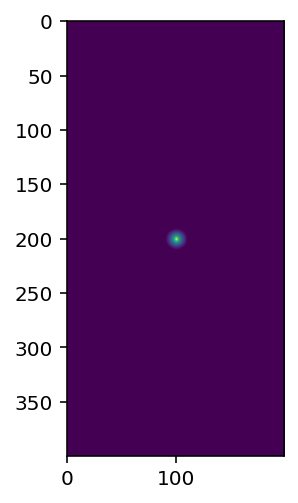

In [24]:
plt.imshow(S_3D[24, :, :])

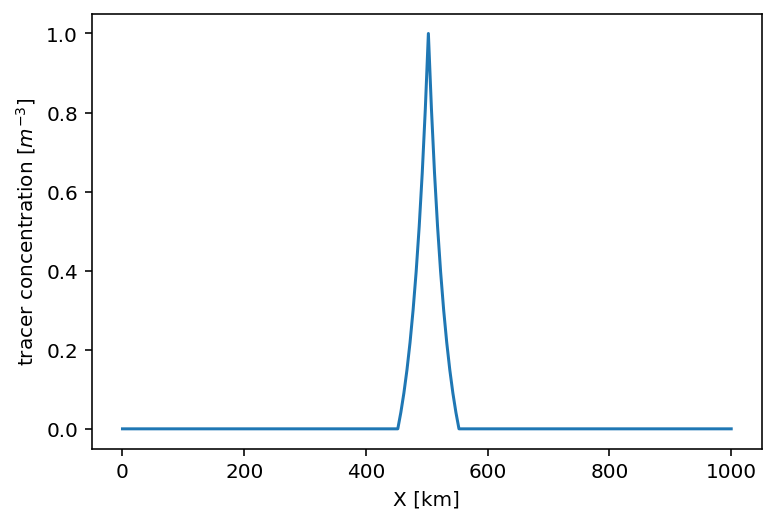

In [26]:
plt.plot(X, S_3D[24,200,:])
plt.xlabel('X [km]')
plt.ylabel(r'tracer concentration [$m^{-3}$]')
plt.show()

In [27]:
writefield("salinity_tracer_point.bin", S_3D)

write to file: salinity_tracer_point.bin
changed dtype to float32
